<a href="https://colab.research.google.com/github/PandukaNandara/machine-learning-model-for-nasa/blob/main/Solution_184161A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<a href="https://medium.com/@pandukanandara/choosing-the-best-regression-technique-for-nasa-airfoil-self-noise-dataset-b16d17368f3d">CLICK HERE TO SEE THE BLOG POST</a>
---

# (a)


In the following line we will load the dataset. And also we will install the necessary libraries.

In [ ]:
import seaborn as sns

from scipy.stats import skew
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn import datasets
import numpy as np

from statistics import mean 
from sklearn.preprocessing import PolynomialFeatures

from sklearn import metrics
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Machine Learning and Pattern Recognition - CM 4370/184161A-ML-ASSIGNMENT/AirfoilSelfNoise.csv')
df.head(10) # reading the first 10 rows

,f,alpha,c,U_infinity,delta,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
5,2500,0.0,0.3048,71.3,0.002663,125.571
6,3150,0.0,0.3048,71.3,0.002663,125.201
7,4000,0.0,0.3048,71.3,0.002663,123.061
8,5000,0.0,0.3048,71.3,0.002663,121.301
9,6300,0.0,0.3048,71.3,0.002663,119.541


## Produce Histogram

In [ ]:
def plot_histogram(df):
  df.hist(figsize=(20, 20))
  plt.show()

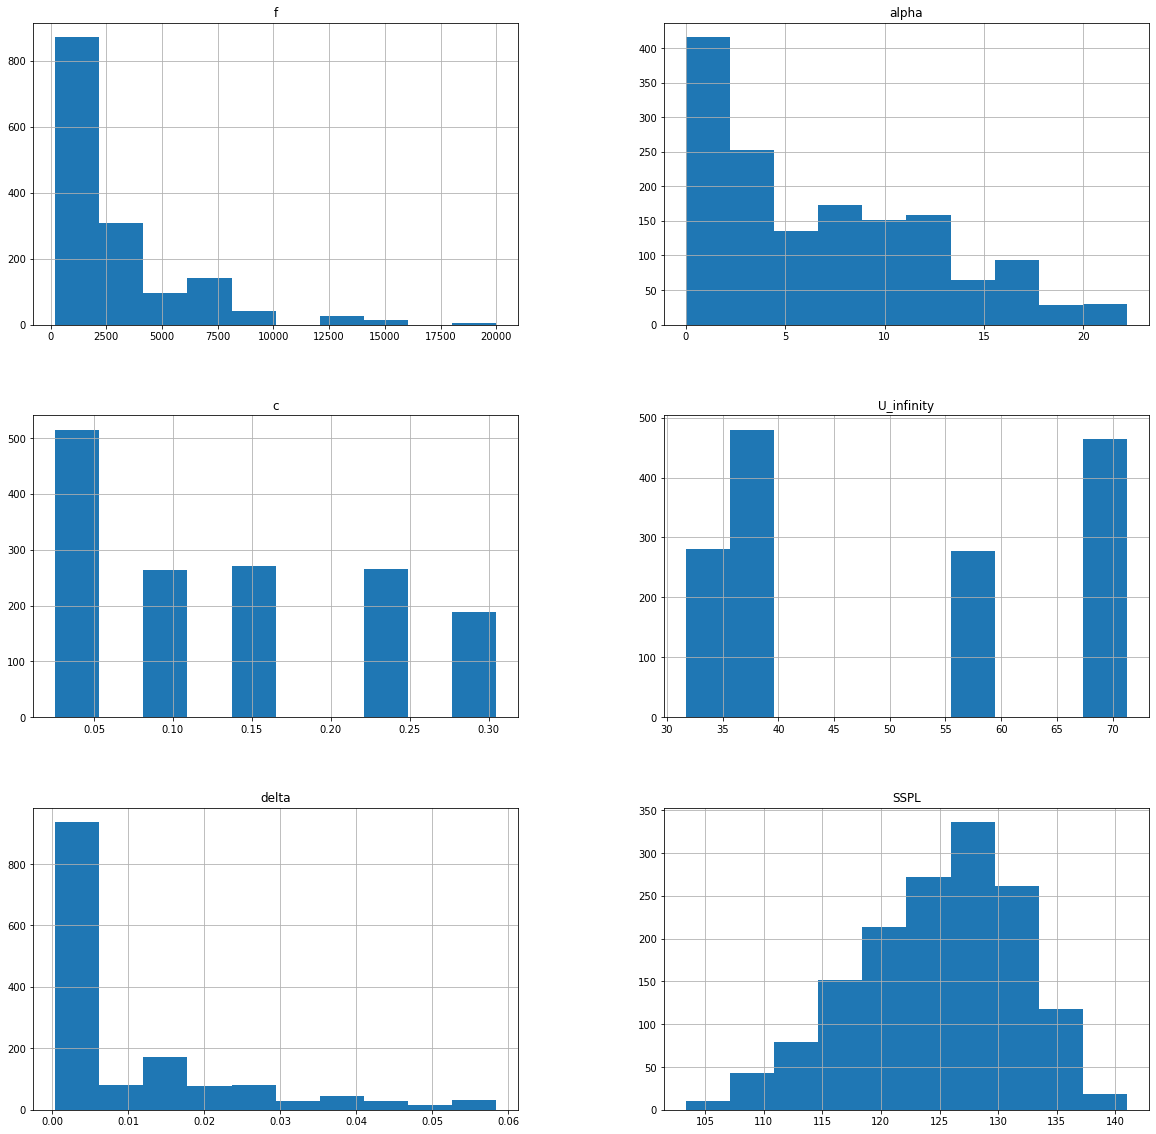

In [ ]:
plot_histogram(df)

## I. Handling Missing values and Outliers

Let's first find the missing values.



In [ ]:
df.isna().sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
SSPL          0
dtype: int64

There is no missing values from any columns. Let's find the outliers. Let's draw a box plot for all columns.

In [ ]:

def plot_boxplot(df):  # Draw box plot for each columns 
  for column in df.columns:
    df.boxplot(column=df[column])
    plt.title(column)


<Figure size 1224x72 with 0 Axes>

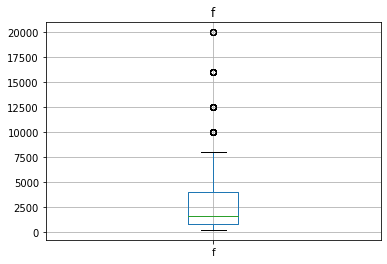

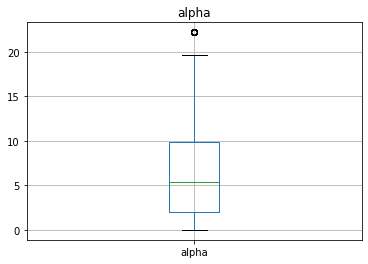

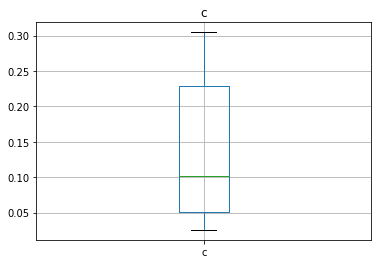

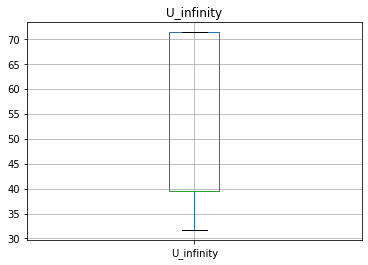

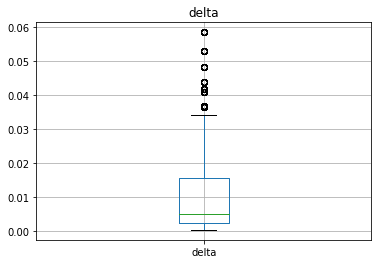

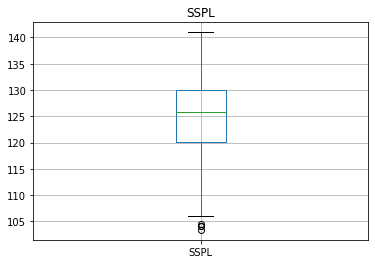

In [ ]:
plot_boxplot(df)

Let's check number of outlier for each columns.

In [ ]:
max_val = df.quantile(0.95)
min_val = df.quantile(0.05)
print(((df < min_val) | (df > max_val)).sum())
print("Number of records: ", len(df))

f              79
alpha          58
c               0
U_infinity      0
delta         133
SSPL          152
dtype: int64
Number of records:  1503


As in the above plots there are outliers in the columns `f`, `alpha`, `delta` and `SSPL`. There are only 1503 records in the dataset. Therefore we cannot delete the outliers. Instead let's replace the outlier values with IQR.

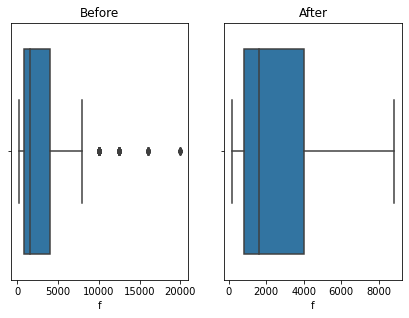

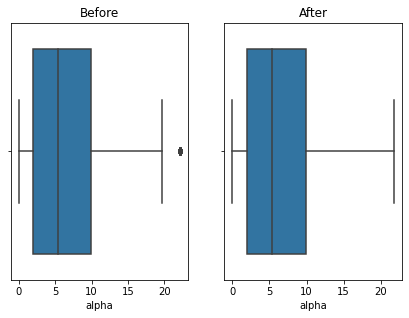

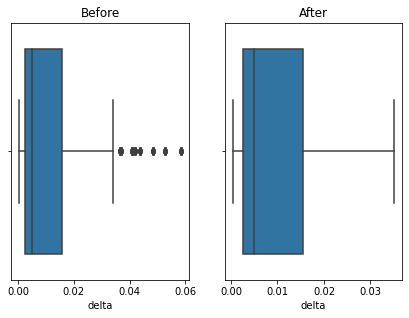

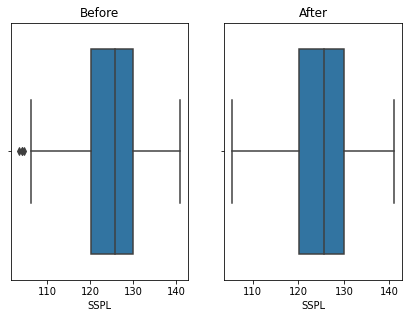

In [ ]:
cols = ['f', 'alpha', 'delta', 'SSPL']
df2 = df.copy()
for col in cols:
  fig, axes = plt.subplots(1,2)
  plt.tight_layout(0.5)
  sns.boxplot(df[col], ax=axes[0])
  axes[0].title.set_text("Before")
  # Handling outliers
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3-Q1
  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  
  df2[col] = np.where(df2[col] > upper, upper, df2[col])
  df2[col] = np.where(df2[col] < lower, lower, df2[col])
  sns.boxplot(df2[col], orient='v', ax=axes[1])
  axes[1].title.set_text("After")
  plt.show()

In [ ]:
print("Before ", df.shape)
print("After ", df2.shape)

Before  (1503, 6)
After  (1503, 6)


## Produce Q-Q Plot

In [ ]:
def produce_q_q_plot_and_hist(df, cols=df.columns):
  for column in cols:
    plt.figure()

    # fig, axes = plt.subplots(1,2)
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title(column)
    plt.show()
    df[column].hist()
    plt.show()

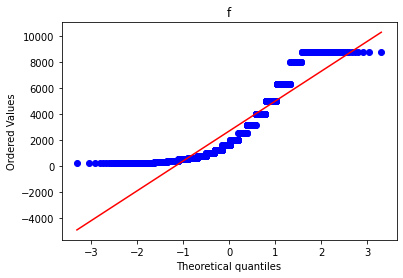

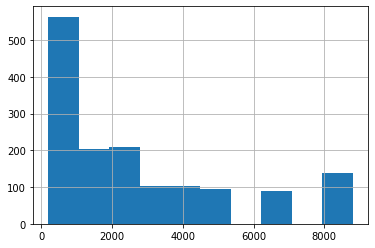

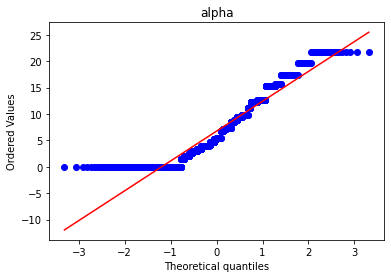

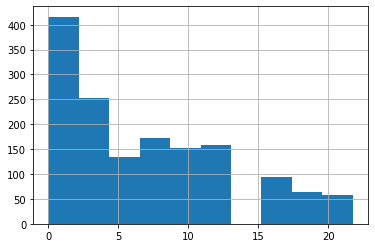

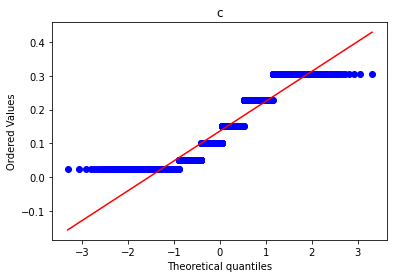

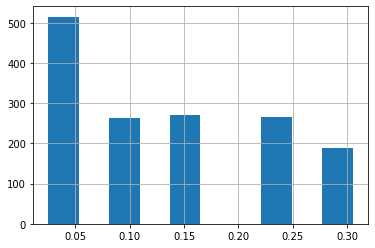

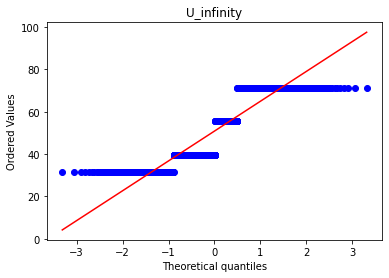

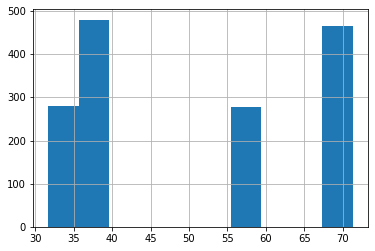

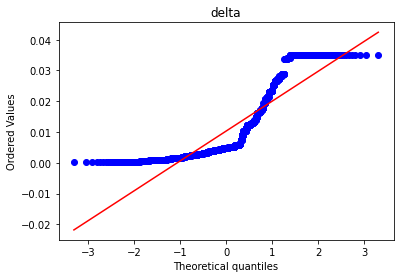

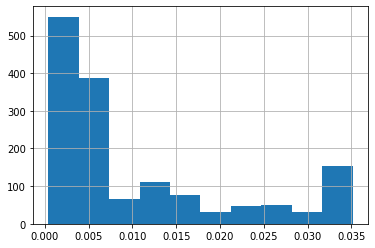

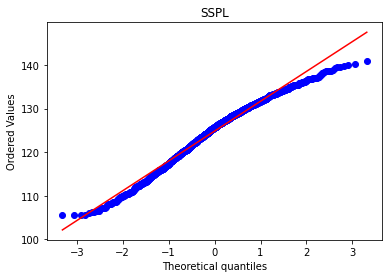

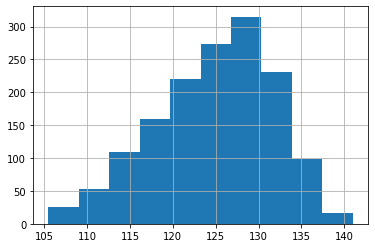

In [ ]:
produce_q_q_plot_and_hist(df2)

## II. Applying Transformation

Seems like the following varaibles have skewed distribution.

| Variable | Skewness | Required Transformation Technique  |
|----------|----------|------------------------------------|
| alpha    | Right    | FunctionTransformer                |
| delta    | Right    | FunctionTransformer                |
| f        | Right    | FunctionTransformer                |



First of all we have to split our dataset to training and testing 8:2 ratio. 

In [ ]:
# We need to seprate the dataset into testing and testing
df3 = df2.copy()
x = df3.drop("SSPL", 1) # Seprating the target
y = pd.DataFrame(df3['SSPL'], columns=["SSPL"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)

# Restting Indexes
x_train = x_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

Apply transformation for `alpha`, `delta` and  `f`.
But before that we need to check the min and max values of these varaibles.

In [ ]:
df3.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.00000
mean,2684.318031,6.773320,0.136548,50.860745,0.010320,124.83975
std,2507.693180,5.895003,0.093541,15.572784,0.010972,6.88753
min,200.000000,0.000000,0.025400,31.700000,0.000401,105.48425
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.19100
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.72100
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.99550
max,8800.000000,21.750000,0.304800,71.300000,0.035137,140.98700


Let's apply log transformation for `f` and `delta`. Since those two varaibles only have non-zero positive values.

In [ ]:
cols = ['f', 'delta']
log_transfomer = FunctionTransformer(np.log, validate=True)

transfomed_df_train = log_transfomer.transform(x_train[cols])

df_new_train = pd.DataFrame(transfomed_df_train, columns=cols)


tansformed_df_test = log_transfomer.transform(x_test[cols])


df_new_test = pd.DataFrame(tansformed_df_test, columns=cols)
for col in cols:
  x_train[col] = df_new_train[col]
  x_test[col] = df_new_test[col]

Applying square roo transformation for alpha.

In [ ]:
cols = ['alpha']

sqrt_transfomer = FunctionTransformer(np.sqrt, validate=False, check_inverse=True)

tansformed_df_train = sqrt_transfomer.transform(x_train[cols])

df_new_train = pd.DataFrame(tansformed_df_train, columns=cols)

tansformed_df_test = sqrt_transfomer.transform(x_test[cols])

df_new_test = pd.DataFrame(tansformed_df_test, columns=cols)

for col in cols:
  x_train[col] = df_new_train[col]
  x_test[col] = df_new_test[col]



---
### After Applying Transformation



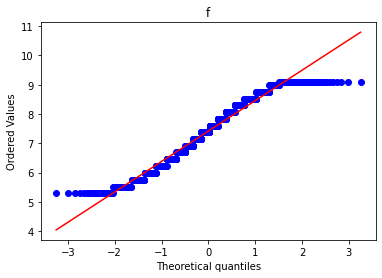

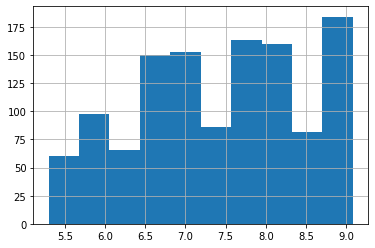

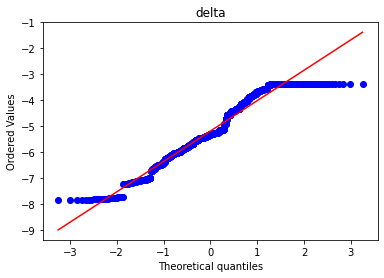

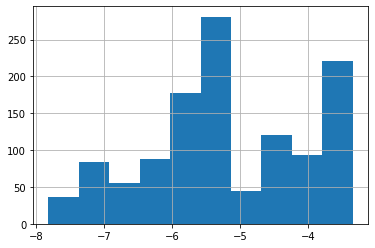

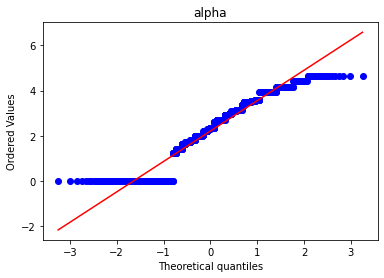

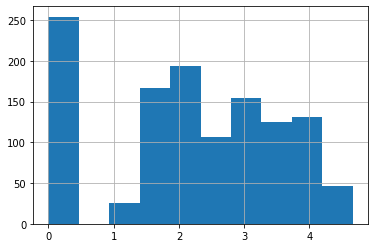

In [ ]:
produce_q_q_plot_and_hist(x_train, ['f', 'delta', 'alpha'])

# III. Apply Feature Coding
Since all varaibles are numerical, we don't need to do this.

# IV. Scale / Standarize the Features

We will appy MinMax Scaler since values cannot be negative.

In [ ]:

scaler = MinMaxScaler() 

scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)

scaler.fit(x_test)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


In [ ]:

scaler = MinMaxScaler()

scaler.fit(y_train)

y_train = pd.DataFrame(scaler.transform(y_train), columns=y_train.columns)

scaler.fit(y_test)

y_test = pd.DataFrame(scaler.transform(y_test), columns=y_test.columns)

Showing the effect of standardization.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2399662ed0>,
      dtype=object)

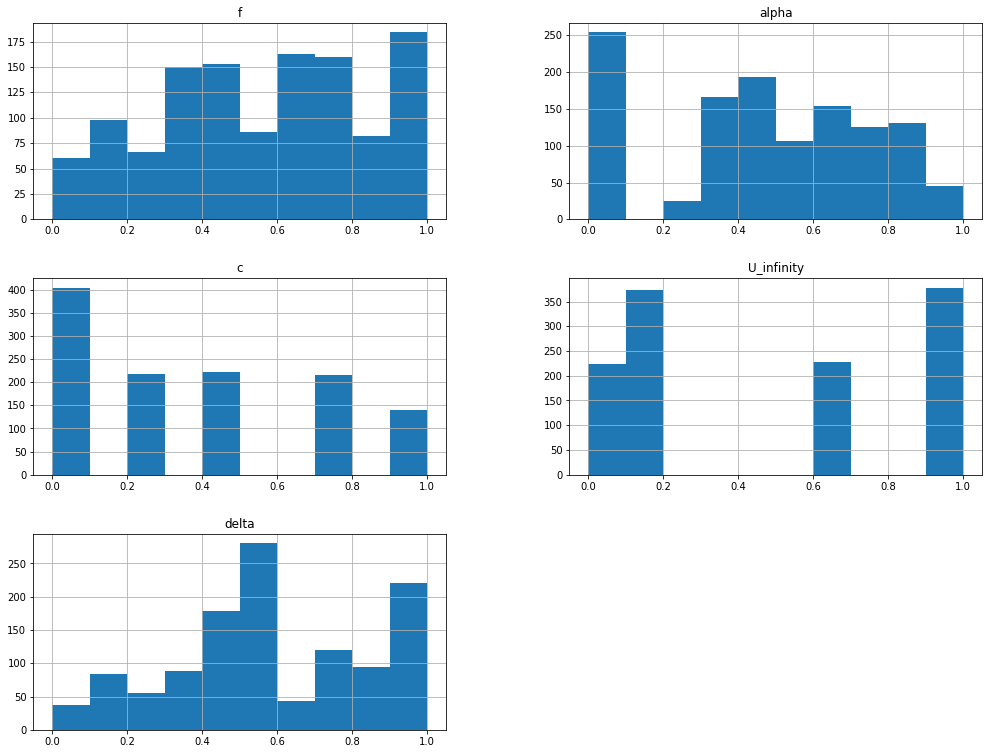

In [ ]:
x_train.hist(figsize = (17,13))

# V. Feature Discritization

In the dataset, there is no varaibles with large range. Therefore we will not apply feature discritization.

# (b)

##  Identify significant and independent features
Let's analyze the correlation among independent features using corrlation matrix.

In [ ]:
x_train.corr()

,f,alpha,c,U_infinity,delta
f,1.000000,-0.296317,-0.005500,0.100582,-0.356695
alpha,-0.296317,1.000000,-0.398284,0.088173,0.846995
c,-0.005500,-0.398284,1.000000,-0.020765,-0.057847
U_infinity,0.100582,0.088173,-0.020765,1.000000,0.022567
delta,-0.356695,0.846995,-0.057847,0.022567,1.000000


Let's plotting the heatmap for the preprocessed dataset features.ing the heatmap for the preprocessed dataset features.

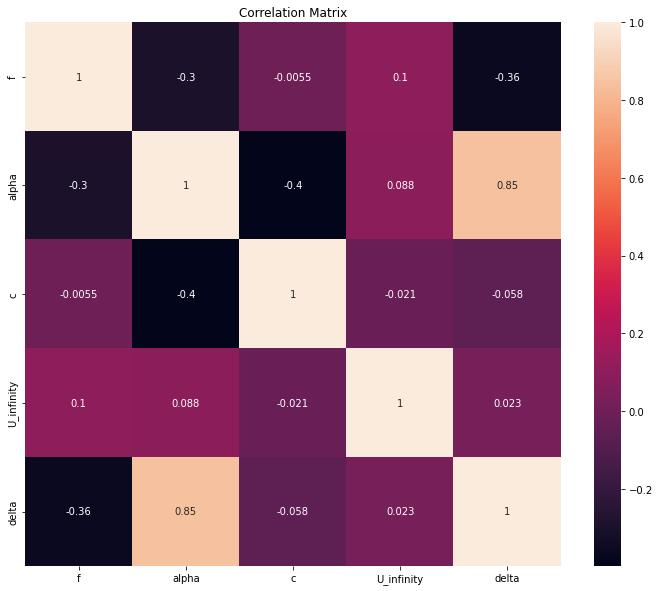

In [ ]:
plt.figure(figsize = (12, 10))

sns.heatmap(x_train.corr(), annot = True)
plt.title("Correlation Matrix")
plt.show()

## Analysing Correlation
*   `SSPL` and `alpha` has high corelation of 0.84.
*   All features can be independent.

Let's plotting the heatmap for preprocessed training dataset.

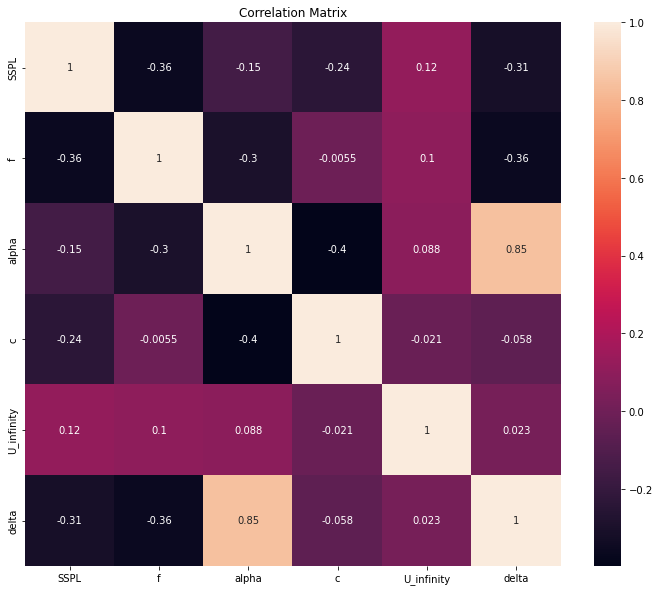

In [ ]:
df_train = pd.concat([y_train, x_train], axis=1, join="inner")
df_train.corr()
plt.figure(figsize = (12, 10))
sns.heatmap(df_train.corr(), annot = True)
plt.title("Correlation Matrix")
plt.show()

## I. Feature Reduction - PCA

Applying PCA.

In [ ]:
pca = PCA()
pca.fit(x_train)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_[:-1].sum())

[0.357414   0.30958325 0.20587951 0.11360726 0.01351598]
0.9864840179401817


Define PCA with n_component 4

In [ ]:
pca = PCA(n_components = 4)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# (c) Predict the value of Y for the test dataset (K =10)

## I. Linear Regression with Corss Validation

Let's apply linear regression with K Fold cross validation.

In [ ]:
trans = PolynomialFeatures(degree=2)

x_train_pca = trans.fit_transform(x_train_pca)
x_test_pca = trans.fit_transform(x_test_pca)
linear_model = LinearRegression()
m = linear_model.fit(x_train_pca, y_train)  # Linear regression

y_pred_linear = linear_model.predict(x_test_pca) # Predicting
y_hat_linear = pd.DataFrame(y_pred_linear, columns=["Predicted SSPL"])
y_hat_linear

,Predicted SSPL
0,0.773062
1,0.673160
2,0.666748
3,0.764941
4,0.400699
...,...
296,0.484713
297,0.530037
298,0.185706
299,0.645144


### ***Prediction vs Actual***

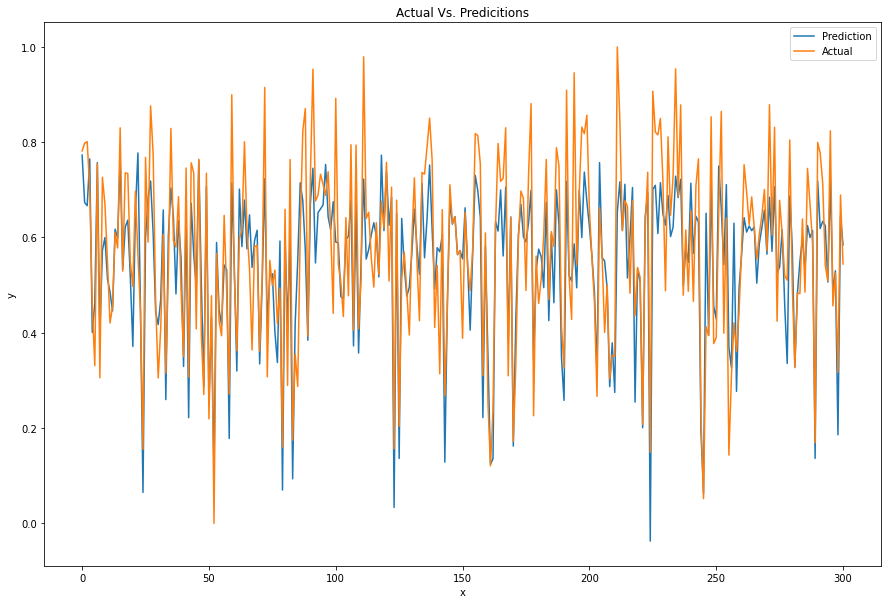

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(y_hat_linear, label = "Prediction")
plt.plot(y_test, label = "Actual")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Actual Vs. Predicitions')
plt.legend()
plt.show()

In [ ]:
x_merged = np.r_[x_train_pca, x_test_pca]
y_merged = np.r_[y_train, y_test]
scores = cross_val_score(m, x_merged, y_merged, cv=10)
pd.DataFrame(scores, columns=['Cross Value Score'])

,Cross Value Score
0,0.746700
1,0.671734
2,0.711842
3,0.744622
4,0.592444
5,0.689983
6,0.740982
7,0.679256
8,0.695329
9,0.711042


In [ ]:
predictions = cross_val_predict(m, x_merged, y_merged, cv=10)
accuracy = metrics.r2_score(y_test, y_hat_linear)
print("Accuracy : %.4f " %(accuracy * 100) + "%")

Accuracy : 70.3738 %


## II Lasso Regression with Cross Validation

In [ ]:

cross_val_scores_lasso = [] 
d = [] 
for i in range(1, 10): 
    lasso = Lasso(alpha = (i * 0.25)) 
    lasso.fit(x_train_pca, y_train) 
    scores = cross_val_score(lasso, x_test_pca, y_test, cv = 5) 
    avg_cross_val_score = mean(scores) * 100
    cross_val_scores_lasso.append(avg_cross_val_score) 
    d.append(i * 0.25) 

printed = []
for i in range(0, len(d)): 
  printed.append([d[i], cross_val_scores_lasso[i]])

pd.DataFrame(printed)


,0,1
0,0.25,-2.603499
1,0.50,-2.603499
2,0.75,-2.603499
3,1.00,-2.603499
4,1.25,-2.603499
5,1.50,-2.603499
6,1.75,-2.603499
7,2.00,-2.603499
8,2.25,-2.603499


In [ ]:
lasso_model = Lasso(alpha = 0.5) 
lasso_model.fit(x_train_pca, y_train) 
print(lasso_model.score(x_test_pca, y_test))

-0.02857781221929323


## III. Ridge Regression With Cross Validation

In [ ]:
cross_val_scores_ridge = [] 
d = []

for i in range(30, 50):
  ridge = Ridge(alpha = i * 0.9) 
  ridge.fit(x_train_pca, y_train)
  # Since K-Fold=10
  scores = cross_val_score(ridge, x_test_pca, y_test, cv = 5)
  avg_cross_val_score = mean(scores)*100
  cross_val_scores_ridge.append(avg_cross_val_score) 
  d.append(i * 0.9)

printed = []

for i in range(0, len(d)): 
  printed.append([d[i], cross_val_scores_ridge[i]])
pd.DataFrame(printed)


,0,1
0,27.0,25.677157
1,27.9,25.178292
2,28.8,24.696864
3,29.7,24.231963
4,30.6,23.782747
5,31.5,23.348428
6,32.4,22.928272
7,33.3,22.521593
8,34.2,22.127748
9,35.1,21.746137


In [ ]:
ridge_model = Ridge(alpha = 34) 
ridge_model.fit(x_train_pca, y_train) 
  
print(ridge_model.score(x_test_pca, y_test)) 

0.45149574803672043


## (d) Applicability of Regression Model

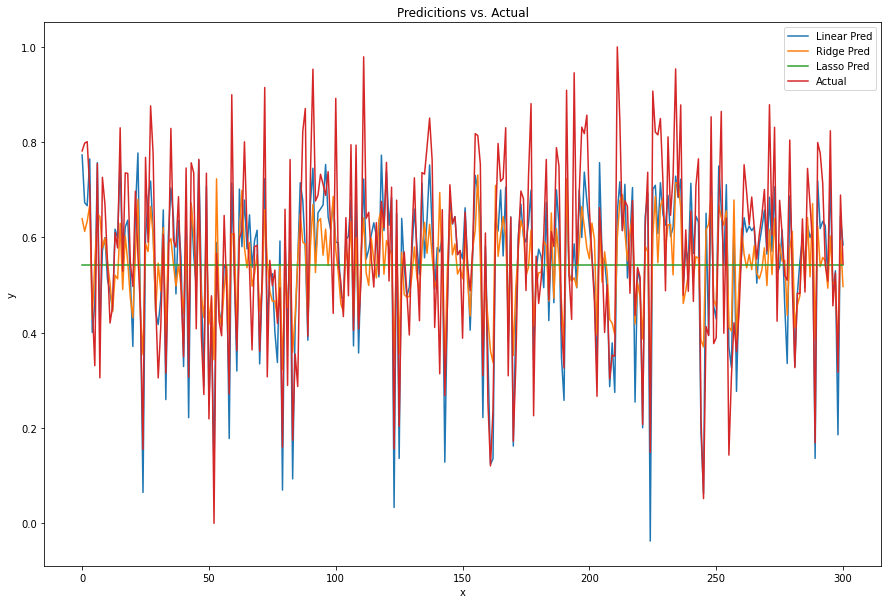

In [ ]:
linear_predictions = linear_model.predict(x_test_pca)
ridge_predictions = ridge_model.predict(x_test_pca)
lasso_predictions = lasso_model.predict(x_test_pca)
plt.figure(figsize = (15, 10))
plt.plot(linear_predictions, label = "Linear Pred")
plt.plot(ridge_predictions, label = "Ridge Pred")
plt.plot(lasso_predictions, label = "Lasso Pred")
plt.plot(y_test, label = "Actual")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicitions vs. Actual')
plt.legend()
plt.show()

Let's evaluate the 3 models.
Let's calculate 
*   Root Mean Squared Error
*   Mean Squared Error
*   Mean Absolute Error

For the three models.


In [ ]:
printed = []
predictions = [linear_predictions, lasso_predictions, ridge_predictions]
prediction_label = ['Linear Regression', 'Lasso Regression', 'Ridge Regression'];

count = 0
for pred in predictions:
  p = [prediction_label[count]]
  p.append(metrics.mean_absolute_error(pred, y_test))
  mse = metrics.mean_squared_error(pred, y_test);
  p.append(mse)
  p.append(np.sqrt(mse))
  printed.append(p)
  count = count + 1
pd.DataFrame(printed, columns=['', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error'])


,,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,Linear Regression,0.080604,0.010943,0.104610
1,Lasso Regression,0.159561,0.037993,0.194919
2,Ridge Regression,0.114722,0.020261,0.142340


According to the above table Linear Regression has the hightest cross predicted accuracy.